In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers, utils, activations, losses, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
# Define Parameters
num_classes = 3
IMG_SIZE = 224

In [3]:
# download from google drive or upload file by yourself
# https://drive.google.com/file/d/1QHVsHvYPUw6IhOYn7ayUkZ_L95KVcPQ4/view?usp=sharing
!gdown --id '1QHVsHvYPUw6IhOYn7ayUkZ_L95KVcPQ4' --output retina-dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1QHVsHvYPUw6IhOYn7ayUkZ_L95KVcPQ4
To: /content/retina-dataset.zip
35.1MB [00:00, 164MB/s]


In [4]:
# unzip dataset file
!unzip -q retina-dataset.zip

#### Data Visualization

In [5]:
paths = glob('retina-train/*.jpeg')
paths_test = sorted(glob('retina-test/*.jpeg'))
len(paths), len(paths_test)

(2086, 522)

retina-train/16802_right_2.jpeg


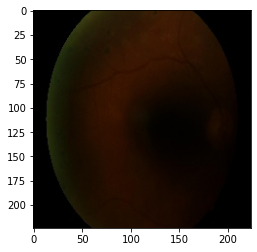

In [6]:
idx = 7
path = paths[idx]
img = cv2.imread(path)[:,:,::-1]
plt.imshow(img)
print(path)

In [7]:
all_filenames = [os.path.split(p)[1] for p in paths] # path -> ***.jpeg
print(all_filenames[:3])
all_cls = [int(name.split('.')[0].split('_')[-1]) for name in all_filenames] # ***.jpeg -> 0~4
print(all_cls[:3])

['10147_right_1.jpeg', '5082_left_0.jpeg', '30297_left_2.jpeg']
[1, 0, 2]


<BarContainer object of 3 artists>

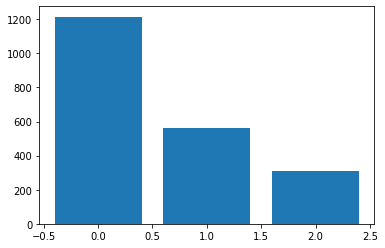

In [8]:
# Class distribution
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)

#### Prepare Data

In [9]:
# split dataset
path_train, path_val = train_test_split(paths, test_size=0.2)

len(path_train), len(path_val)

(1668, 418)

In [10]:
def create_dataset(paths, img_size=IMG_SIZE, num_classes=num_classes, test=False):
    num_data = len(paths)
    x_data = np.empty((num_data, img_size, img_size, 3))
    y_data = np.empty((num_data))

    for i, path in enumerate(tqdm(paths)):
        # read image and preprocess
        img = cv2.imread(path)[:,:,::-1]
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.
        x_data[i] = img

        if not test:
            # read class label
            filename = os.path.split(path)[1]
            cls = int(filename.split('.')[0].split('_')[-1]) # '38200_left_0.jpeg' -> 0
            y_data[i] = cls
    if not test:
        y_data = utils.to_categorical(y_data, num_classes=num_classes)
        return x_data, y_data
    else:
        return x_data

In [11]:
x_train, y_train = create_dataset(path_train)
x_val, y_val = create_dataset(path_val)
x_test = create_dataset(paths_test, test=True)

100%|██████████| 522/522 [00:01<00:00, 479.08it/s]


In [12]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1668, 224, 224, 3), (1668, 3), (418, 224, 224, 3), (418, 3))

#### Prepare model

In [18]:
# # Build your own model
model = models.Sequential([
    layers.InputLayer((IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3),
    layers.BatchNormalization(),
    layers.PReLU(),
    layers.Conv2D(filters=64, kernel_size=3),
    layers.BatchNormalization(),
    layers.PReLU(),
    layers.MaxPool2D(2),
    layers.Conv2D(filters=64, kernel_size=3),
    layers.BatchNormalization(),
    layers.PReLU(),
    layers.Conv2D(filters=64, kernel_size=3),
    layers.BatchNormalization(),
    layers.PReLU(),
    layers.MaxPool2D(2),
    layers.Conv2D(filters=64, kernel_size=3),
    layers.BatchNormalization(),
    layers.PReLU(),
    layers.Conv2D(filters=64, kernel_size=3),
    layers.BatchNormalization(),
    layers.PReLU(),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(128),
    layers.PReLU(),
    layers.Dense(num_classes, activation='softmax')
])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_7 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 222, 222, 64)      256       
_________________________________________________________________
p_re_lu_7 (PReLU)            (None, 222, 222, 64)      3154176   
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 220, 220, 64)      36928     
_________________________________________________________________
batch_normalization_9 (Batch (None, 220, 220, 64)      256       
_________________________________________________________________
p_re_lu_8 (PReLU)            (None, 220, 220, 64)     

In [20]:
model.compile(optimizer='adam', 
       loss=losses.categorical_crossentropy, 
       metrics=[metrics.categorical_accuracy])

In [21]:
logs = model.fit(x_train, y_train,
          batch_size=64,
          epochs=9,
          validation_data=(x_val, y_val))

Epoch 1/9
27/27 [==============================] - 42s 2s/step - loss: 4.1375 - categorical_accuracy: 0.4514 - val_loss: 1.0163 - val_categorical_accuracy: 0.5455
Epoch 2/9
27/27 [==============================] - 40s 1s/step - loss: 0.9982 - categorical_accuracy: 0.5881 - val_loss: 1.0120 - val_categorical_accuracy: 0.5455
Epoch 3/9
27/27 [==============================] - 40s 1s/step - loss: 0.9707 - categorical_accuracy: 0.5815 - val_loss: 1.0001 - val_categorical_accuracy: 0.5455
Epoch 4/9
27/27 [==============================] - 40s 1s/step - loss: 0.9673 - categorical_accuracy: 0.5899 - val_loss: 0.9997 - val_categorical_accuracy: 0.5455
Epoch 5/9
27/27 [==============================] - 40s 1s/step - loss: 0.9482 - categorical_accuracy: 0.5905 - val_loss: 0.9977 - val_categorical_accuracy: 0.5455
Epoch 6/9
27/27 [==============================] - 40s 1s/step - loss: 0.9579 - categorical_accuracy: 0.5893 - val_loss: 0.9999 - val_categorical_accuracy: 0.5455
Epoch 7/9
27/27 [=====

#### Make Submission file

In [17]:
predictions = np.argmax(model.predict(x_test), axis=-1)

df = pd.DataFrame()
df['Id'] = [p.split(os.sep)[-1] for p in paths_test]
df['Category'] = predictions
df.to_csv('submission.csv', index=None)
df

,Id,Category
0,10017_left.jpeg,0
1,10031_right.jpeg,0
2,10150_left.jpeg,0
3,10154_right.jpeg,0
4,10440_right.jpeg,0
...,...,...
517,9608_left.jpeg,1
518,9673_right.jpeg,0
519,9690_left.jpeg,0
520,9717_right.jpeg,0
